In [2]:
import librosa
import numpy as np
from birdnetlib import analyzer, Recording
import operator
import matplotlib.pyplot as plt
from scipy import signal,ndimage

load_custom_models
Custom model loaded.
loading custom classifier labels
Labels loaded.
load model False
Model loaded.
Labels loaded.
load_species_list_model
Meta model loaded.
41 55


IndexError: boolean index did not match indexed array along dimension 0; dimension is 55 but corresponding boolean dimension is 41

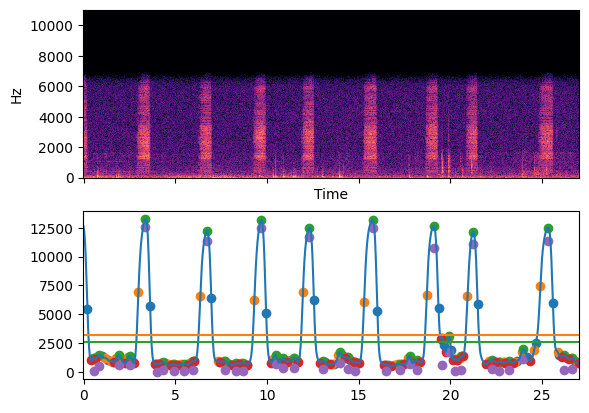

In [18]:
an = analyzer.Analyzer(classifier_model_path=r"C:\Users\plaf\Music\ALAN_training\tytalb_hissing_cclassifier.tflite",
                       classifier_labels_path=r"C:\Users\plaf\Music\ALAN_training\tytalb_hissing_cclassifier_Labels.txt")
af_path = r"c:\Users\plaf\Music\ALAN_training\audiofiles\87_MuristHautDing_20230627_220000.WAV"
# rec = Recording(an, af_path)
dur = 27
dur_birdnet = 3
subseg_dur = .75
tstart = 2000

y, sr = librosa.load(af_path, sr=48000, mono=True, res_type="kaiser_fast", offset = tstart, duration=dur)
sample_subseg_dur = int(subseg_dur * sr)
sample_dur = int(dur * sr)
sample_dur_birdnet = int(dur_birdnet * sr)

n_fft = 2048
hop_length = n_fft
S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
spec = librosa.amplitude_to_db(np.abs(S))
spec_sum = np.sum(spec, axis=0)
# spec_sum = (spec_sum-np.min(spec_sum))/(np.max(spec_sum)-np.min(spec_sum))
spec_sum -= np.min(spec_sum)
conv = ndimage.gaussian_filter1d(spec_sum, 2)
# conv = ndimage.gaussian_filter1d(conv, 10)

summit = np.zeros_like(conv, dtype=np.bool_)
 # "<" guarantees the existance of only one point in the neighborhood
summit[1:-1] = (conv[:-2] < conv[1:-1]) & (conv[1:-1] >= conv[2:])
summit_i = np.flatnonzero(summit)

valley = np.zeros_like(summit)
valley[1:-1] = (conv[:-2] > conv[1:-1]) & (conv[1:-1] <= conv[2:])
valley_i = np.flatnonzero(valley)

valley[0] = summit_i[0] < valley_i[0]
valley[-1] = summit_i[-1] > valley_i[-1]

valley_i = np.flatnonzero(valley)


dconv = np.diff(conv)

dsummit = np.zeros_like(summit)
dsummit[2:-1] = (dconv[:-2] > dconv[1:-1]) & (dconv[1:-1] <= dconv[2:])
dsummit_i = np.flatnonzero(dsummit)

dsummit[1] = summit_i[0] < dsummit_i[0]

dvalley = np.zeros_like(summit)
dvalley[2:-1] = (dconv[:-2] < dconv[1:-1]) & (dconv[1:-1] >= dconv[2:])
dvalley_i = np.flatnonzero(dvalley)

dvalley[-2] = summit_i[-1] > dvalley_i[-1]




dsummit_i = np.flatnonzero(dsummit)
print(len(summit_i), len(dsummit_i))
dvalley_i = np.flatnonzero(dvalley)


fig, ax = plt.subplots(nrows=2, sharex=True)

times_spec = np.linspace(0, dur, spec.shape[1])

librosa.display.specshow(spec, x_coords = times_spec, x_axis='time', y_axis='linear', ax=ax[0])

l = len(conv)
times_plot = np.linspace(0, dur, l)
pow_threshold = np.mean(conv)

ax[1].plot(times_plot, conv)
ax[1].plot(times_plot, [pow_threshold]*l)
ax[1].scatter(times_plot[dsummit_i], conv[dsummit_i]) 
ax[1].scatter(times_plot[dvalley_i], conv[dvalley_i])
ax[1].scatter(times_plot[summit_i], conv[summit_i])
ax[1].scatter(times_plot[valley_i], conv[valley_i])

previous_valley = conv[valley_i[:-1]]
next_valley = conv[valley_i[1:]]
# ax[1].scatter(times_plot[previous_valley], conv[previous_valley])

# ax[1].scatter(times_plot[next_dvalley], conv[next_dvalley])
d = np.stack([previous_valley, next_valley])
spikes = conv[summit] - np.mean(d, axis=0)
# spikes[0] -= spikes[1]
# spikes[1:-1] -= (spikes[:-2] + spikes[2:])/2
# spikes[-1] -= spikes[-2]
ax[1].scatter(times_plot[summit_i], spikes)

half_back = sample_subseg_dur // 2


# ax[1].plot([np.median(conv)] * len(conv) )
px_to_sample = len(y) / len(conv)
# subseg_starts = ((np.flatnonzero(summit & (conv[1:-1] > pow_threshold)) + 1) * px_to_sample).astype(np.int64) - int(sample_subseg_dur / 2)
mask = np.zeros_like(y, dtype=np.bool_)
thresh = np.mean(spikes)
ax[1].plot(times_plot, [thresh]*len(conv))
mask[summit_i[spikes > thresh]] = True
sample_start_mask = np.zeros_like(mask)
sample_start_mask[dvalley_i[spikes > thresh]] = True
sample_start_i = np.flatnonzero(sample_start_mask)
sample_end_mask = np.zeros_like(mask)
sample_end_mask[dsummit_i[spikes > thresh]] = True
sample_end_i = np.flatnonzero(sample_end_mask)

indexes = np.flatnonzero(mask) + 1

# subseg_starts = ((indexes) * px_to_sample).astype(np.int64) - int(sample_subseg_dur / 2)
# subseg_ends = subseg_starts + sample_subseg_dur

subseg_starts = ((sample_start_i) * px_to_sample).astype(np.int64)
subseg_ends =  ((sample_end_i) * px_to_sample).astype(np.int64)



l = len(y)
times_plot = np.linspace(0, dur, l)

ax[1].vlines(times_plot[np.delete(subseg_starts, subseg_starts>len(times_plot))], conv.min(), conv.max(), colors="red")
ax[1].vlines(times_plot[np.delete(subseg_ends, subseg_ends>len(times_plot))], conv.min(), conv.max(), colors="green")

plt.show()

plt.close()


valid_starts = []
valid_ends = []

for ss, se in zip(subseg_starts, subseg_ends):
    y_subseg = np.zeros(dur_birdnet * sr)
    y_ = y[ss: se]
    center = int(sample_dur_birdnet // 2)
    l_half = int(len(y_) // 2)
    start = center - l_half
    print(len(y_), len(y_subseg))
    y_subseg[start: start + len(y_)] = y_
    pred = an.predict_with_custom_classifier(y_subseg)[0]

    # S = np.abs(librosa.stft(y[0:3*sr]))
    # Assign scores to labels
    p_labels = dict(zip(an.labels, pred))

    # Sort by score
    p_sorted = sorted(
        p_labels.items(), key=operator.itemgetter(1), reverse=True
    )

    # Filter by recording.minimum_confidence so not to needlessly store full 8K array for each chunk.
    conf_thresh = .1
    p_sorted = [i for i in p_sorted if i[1] >= conf_thresh]
    if p_sorted:
        print(p_sorted)
        valid_starts.append(ss)
        valid_ends.append(se)

fig, ax = plt.subplots(nrows=2, sharex=True)
times_spec = np.linspace(0, dur, spec.shape[1])
librosa.display.specshow(spec, x_coords = times_spec, x_axis='time', y_axis='linear', ax=ax[0])

l = len(y)
times_plot = np.linspace(0, dur, l)
plt.plot(times_plot, y)
plt.vlines(times_plot[valid_starts], y.min(), y.max(), colors="red")
# plt.vlines(100, y.min(), y.max(), colors="red")
plt.vlines(times_plot[valid_ends], y.min(), y.max(), colors="green")
plt.show()
